In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import copy
import pandas as pd
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from EEGNet import *

from lrp_methods.lrp import LRPModel

In [6]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [7]:
class EarthquakeData(Dataset):
    def __init__(self, h_path, d_path):
        self.c_path = h_path + d_path
        self.h_len = len(h_path)
    
    def __len__(self):
        return len(self.c_path)
    
    def __getitem__(self, idx):
        path = self.c_path[idx]
        start_date = path.split("/")[len(path.split("/"))-1].split(":")[0]
        mid_date = pd.to_datetime(start_date) + pd.Timedelta(days=29)

        if idx > self.h_len:
            y = 1
        else:
            y = 0
            
        X = np.loadtxt(path, delimiter=',', dtype=str).astype(np.float32)

        return X, y, mid_date.strftime('%Y-%m-%d')

In [16]:
class1_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/area1-all/nonSSE/*.csv")
class2_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/area1-all/SSE/*.csv")

In [17]:
dataset = EarthquakeData(class1_paths, class2_paths)

In [18]:
dataset[4587][2]

'1998-09-04'

In [19]:
num_chans = 30
model = EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)
model.load_state_dict(torch.load("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/models/area1/area1_full_data.pth"))
model.eval()
# for x in model.parameters():
#     print(x)

EEGNet(
  (conv1): Conv1d(30, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(30,), stride=(1,), groups=8)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (dropout): Dropout(p=0.5, inplace=False)
  (depthwise_conv): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(2,), groups=16)
  (conv1d_1x1): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool2): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (fc): Linear(in_features=496, out_features=1, bias=True)
)

In [21]:
test_acc = 0
test_dataloader = DataLoader(dataset, 1, shuffle=False)
dates = []
probabilities = []
predicted_labels = []
actual_labels = []

# print(len(test_dataloader))
for test_features, test_labels, date in test_dataloader:
    test_features, test_labels = test_features.to(device), test_labels.to(device)
    # test_features = torch.unsqueeze(test_features, 1)
    test_features = test_features.float()
    test_labels = test_labels.float()
    print(test_features.shape)

    # print(test_labels.shape)
    test_pred = model(test_features)
    # test_pred = torch.squeeze(test_pred)
    # test_loss_item = criterion(test_pred, test_labels)
    test_acc_item = binary_acc(test_pred, test_labels)

    dates.append(date[0])
    probabilities.append(test_pred.item())
    predicted_labels.append(torch.round(test_pred).item())


    actual_labels.append(test_labels.item())
    # test_loss += test_loss_item.item()
    test_acc += test_acc_item.item()

torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 30, 58])
torch.Size([1, 3

KeyboardInterrupt: 

In [168]:
test_acc/len(test_dataloader)

86.92727272727272

In [169]:
predicted_labels[0]

0.0

(array([ 9862.,  9893.,  9921.,  9952.,  9982., 10013., 10043., 10074.,
        10105., 10135., 10166.]),
 [Text(9862.0, 0, '1997-01'),
  Text(9893.0, 0, '1997-02'),
  Text(9921.0, 0, '1997-03'),
  Text(9952.0, 0, '1997-04'),
  Text(9982.0, 0, '1997-05'),
  Text(10013.0, 0, '1997-06'),
  Text(10043.0, 0, '1997-07'),
  Text(10074.0, 0, '1997-08'),
  Text(10105.0, 0, '1997-09'),
  Text(10135.0, 0, '1997-10'),
  Text(10166.0, 0, '1997-11')])

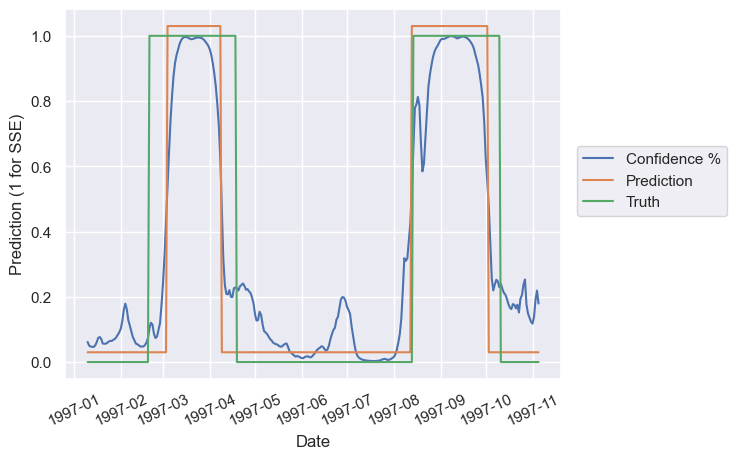

In [225]:
data_frame = pd.DataFrame({'date' : dates, 'probs' : probabilities, 'pred' : predicted_labels, 'actual' : actual_labels})
data_frame['pred'] = data_frame['pred'] + 0.03
data_frame = data_frame.sort_values(by='date')
data_frame['date'] = pd.to_datetime(data_frame['date'])

r_n = range(00, 300)

plt.plot(data_frame['date'].iloc[r_n], data_frame['probs'].iloc[r_n])
plt.plot(data_frame['date'].iloc[r_n], data_frame['pred'].iloc[r_n])
plt.plot(data_frame['date'].iloc[r_n], data_frame['actual'].iloc[r_n])
plt.legend(["Confidence %" , "Prediction", "Truth"], bbox_to_anchor =(1.35, 0.65))
plt.xlabel("Date")
plt.ylabel("Prediction (1 for SSE)")
plt.xticks(rotation=25)

# data_frame.to_csv("A1andA2model150epochs-A3predicted.csv")


In [226]:
# selected_stations = ['940086', '950434' ,'950433' ,'950436' ,'950437' ,'950448' ,'950449' ,'940085' ,'940084' ,'950443']

lrp_model = LRPModel(model)

date_in_q = '1997-06-01'

found_index = 0
for index in range(len(dataset)):
    if (dataset[index][2] == date_in_q):
        print("Is found")
        found_index = index
        break;

picked_point = dataset[found_index]
picked_point_actual = picked_point[1]

# x = dataset[230][0]
picked_point = torch.from_numpy(picked_point[0]).to(device)
x = torch.unsqueeze(picked_point, 0)

print("For date: ", date_in_q)
print("Actual: ", picked_point_actual)
print("Predicted: ", torch.round(model(x)).item())

rel = lrp_model.forward(x)
# # # r.shape
rel = rel.numpy()

Is found
For date:  1997-06-01
Actual:  0
Predicted:  0.0


Text(0.5, 1.0, "Area 1 with model 1&2. Predicted: No. Date: '1997-06-01")

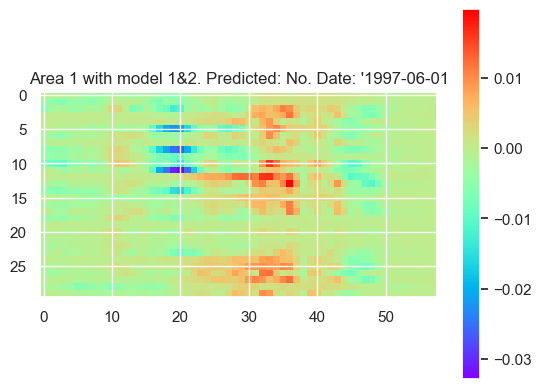

In [227]:
stations = []

sns.set()
for index in range(rel.shape[0]):
    stations.append(sum(rel[index]))

# plt.plot(stations)

plt.imshow(rel, cmap="rainbow")
# plt.hlines(3, 10, 10, linestyle='dashed', linewidth=5, color="black")
plt.colorbar()
plt.title("Area 1 with model 1&2. Predicted: No. Date: '1997-06-01")

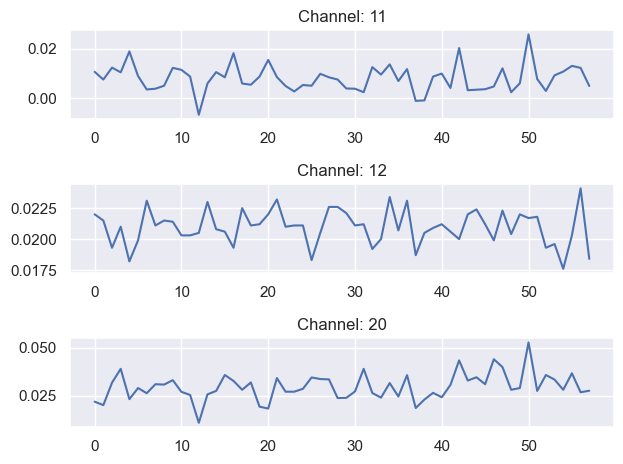

In [228]:
fig, axs = plt.subplots(3)
np_arr = picked_point.detach().cpu().numpy()

interest_ch = [11, 12, 20]
for i, chan in enumerate(interest_ch):
    axs[i].plot(np_arr[interest_ch[i]])
    axs[i].set_title("Channel: " + str(interest_ch[i]))
fig.tight_layout()

Testing on unknown data in the same area

In [58]:
class NewInputData(Dataset):
    def __init__(self, path):
        self.path = path
        self.h_len = len(path)
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        path = self.path[idx]
        start_date = path.split("/")[len(path.split("/"))-1].split(":")[0]
        mid_date = pd.to_datetime(start_date) + pd.Timedelta(days=29)
            
        X = np.loadtxt(path, delimiter=',', dtype=str).astype(np.float32)

        return X, mid_date.strftime('%Y-%m-%d')

In [14]:
# load in data from after 2012
after_paths = glob.glob("./58daysdata/58days-revamped-area1-rad=0.5/after/*.csv")

# create dataset
after_2012 = NewInputData(after_paths)

# put into dataloader
after_2012_dataloader = DataLoader(after_2012, 1, shuffle=False)

probabilities_a = []
dates_a = []
predicted_labels_a = []

for a_features, date in after_2012_dataloader:
    a_features = a_features.to(device)
    
    # predict
    test_pred = model(a_features)

    # add to arrays
    dates_a.append(date[0])
    probabilities_a.append(test_pred.item())
    predicted_labels_a.append(torch.round(test_pred).item())
  
    

In [16]:
data_frame_a = pd.DataFrame({'date' : dates_a, 'probs' : probabilities_a, 'pred' : predicted_labels_a})
data_frame_a['pred'] = data_frame_a['pred'] + 0.03
data_frame_a = data_frame_a.sort_values(by='date')
data_frame_a['date'] = pd.to_datetime(data_frame_a['date'])

r_n = range(0, 200)

plt.plot(data_frame_a['date'].iloc[r_n], data_frame_a['probs'].iloc[r_n])
plt.plot(data_frame_a['date'].iloc[r_n], data_frame_a['pred'].iloc[r_n])

IndexError: positional indexers are out-of-bounds

In [17]:
# selected_stations = ['940086', '950434' ,'950433' ,'950436' ,'950437' ,'950448' ,'950449' ,'940085' ,'940084' ,'950443']

lrp_model = LRPModel(model)

date_in_q = '2000-03-28'

found_index = 0
for index in range(len(dataset)):
    if (dataset[index][2] == date_in_q):
        found_index = index
        break;

picked_point = dataset[found_index]
picked_point_actual = picked_point[1]

# x = dataset[230][0]
picked_point = torch.from_numpy(picked_point[0]).to(device)
x = torch.unsqueeze(picked_point, 0)

print("For date: ", date_in_q)
print("Actual: ", picked_point_actual)
print("Predicted: ", torch.round(model(x)).item())

rel = lrp_model.forward(x)
# # # r.shape
rel = rel.numpy()

For date:  2000-03-28
Actual:  0
Predicted:  1.0


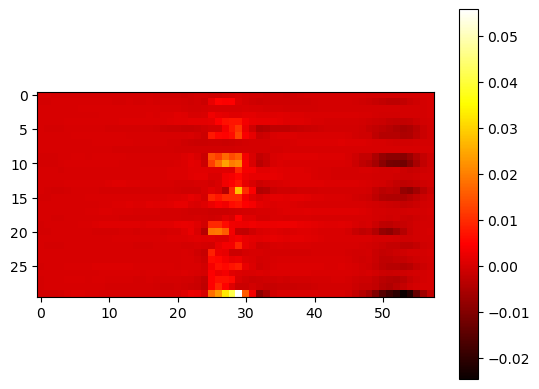

In [229]:
stations = []

for index in range(rel.shape[0]):
    stations.append(sum(rel[index]))

# plt.plot(stations)

plt.imshow(rel, cmap="hot")
plt.colorbar()

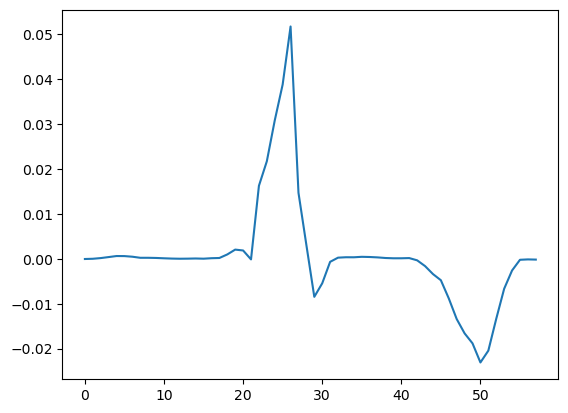

In [176]:
plt.plot(rel[29])